In [1]:
import matplotlib.pyplot as plt

from random import shuffle
from tqdm import tqdm

In [2]:
import sys

import sys
sys.path.append('../')

In [3]:
from circuits.generate_circuits import generate_random_circuit
from circuits.pqc_circuits import qiskit_PQC_RZRXRZ_unique, pennylane_PQC_RZRXRZ_unique

from simulator.simulate import run_circuit_pennylane

from models.pennylane_models import SimplePennylaneQuantumStateModel
from models.noise_models import BitPhaseFlipNoise

from utils.loss_functions import QuantumFidelityLoss

In [4]:
NUM_QUBITS = 5
NUM_GATES = 50


In [5]:
noise_model = BitPhaseFlipNoise()

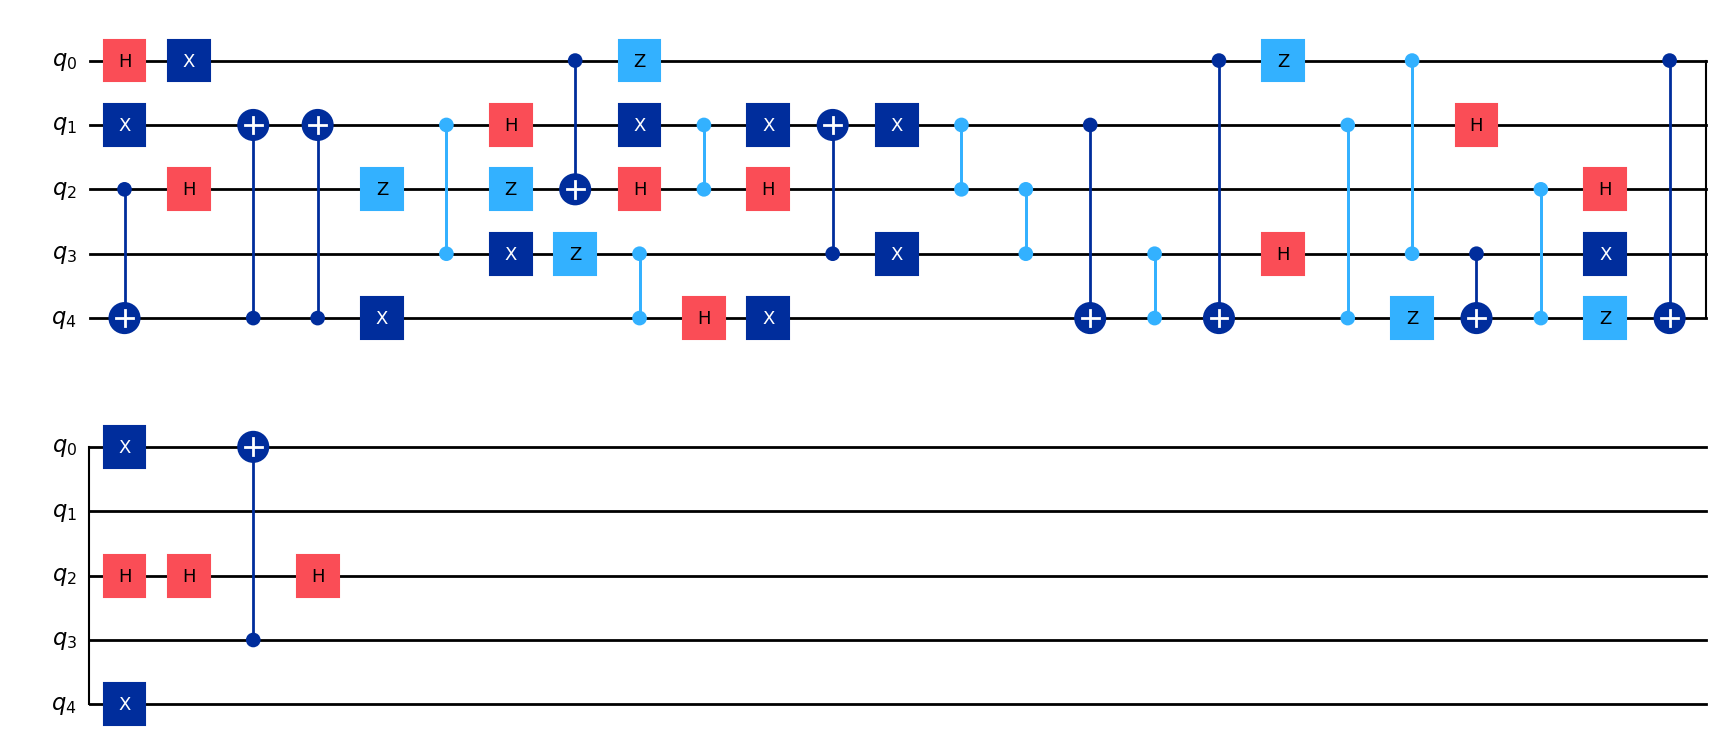

In [6]:
circuit = generate_random_circuit(NUM_QUBITS, NUM_GATES, seed=42)
circuit.draw('mpl')